<a href="https://colab.research.google.com/github/ThinhNguyen209/CS336.L11.KHTN/blob/main/Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BASELINE PHÂN LOẠI CHỦ ĐỀ

1. TIỀN XỬ LÍ
  - TÁCH TỪ
  - LOẠI BỎ STOPWORDS
  - CHIA DATASET: 
    - TEST: CHỌN NGẪU NHIÊN Ở MỖI CLASS ĐỂ TẠO THÀNH 5000 MẪU TEST
    - TRAIN: TỪ 15000 MẪU CÒN LẠI TRONG DATASET - CHỌN NGẪU NHIÊN Ở MỖI CLASS ĐỂ TẠO THÀNH 1000, 3000, 5000,...,15000 MẪU TRAIN   
2. RÚT TRÍCH ĐẶC TRƯNG
  - NAIVE BAYES
  - TF-IDF
3. TRAINING:
  - MODEL NAIVE BAYES
  - MODEL KNN
4. TESTING
5. VẼ ĐỒ THỊ SO SÁNH ACCURACY GIỮA NAIVE BAYES VÀ KNN QUA TỪNG TẬP DỮ LIỆU TRAIN CÓ KÍCH THƯỚC TỪ 1000, 3000, 5000,...,15000

In [ ]:
!pip install wordsegment

     |████████████████████████████████| 4.8MB 5.7MB/s 


In [ ]:
import numpy as np
import glob
import os
import random
from random import sample

#SỬ DỤNG TOOL TÁCH TỪ 
from wordsegment import load, segment
load()

#SỬ DỤNG TỪ ĐIỂN STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')



from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

from sklearn.externals import joblib

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


#CÁC HÀM THỰC HIỆN

In [ ]:
#In : List tokens
#Out: List tokens after removing stopwords
def removeStopwords(doc):
  results = [word for word in doc if word not in stopwords.words()]
  return results

In [ ]:
# Title: Tien xu li
# In: List path cua document
# Out: List [document,label]
def getListOfDocument (doc_paths):
  doc_list = []
  for doc_path in doc_paths:
    label = doc_path.split('/')[-2]
    file = open(doc_path, 'r',errors='ignore').read()
    doc = segment(file)
    doc = removeStopwords(doc)
    doc_list.append([doc,label])
  return doc_list

In [ ]:
# In: List document [doc,label]
# Out: Bag of Words (List)
def getBagOfWords (doc_list): 
  bow = []
  for doc,label in doc_list:
    bow += doc
  
  return set(bow)
  

In [ ]:
# In: List Bag of Words, Train Dataset: [doc,label] 
# Out: Array NaiveBayes va Label cho moi document
def getNaiveBayes (BagOfWords, DocumentList):
  NaiveBayes_List = []
  Labels = []
  for doc,label in DocumentList:
    wordfreq = [doc.count(word) for word in BagOfWords]
    wordfreq = np.array(wordfreq)
    NaiveBayes_List.append(wordfreq)
    Labels.append(label)

  return np.array(NaiveBayes_List), np.array(Labels)

In [ ]:
# In: List Bag of Words, Train Dataset: [doc,label] 
# Out: Model Tf-idf, Array tf-idfs, Label cho moi document
def getTf_Idfs (BagOfWords, DocumentList):
  
  Corpus = []
  Labels = []
  for doc, label in DocumentList:
    Corpus += [' '.join(doc)]
    Labels.append(label)

  from sklearn.feature_extraction.text import TfidfVectorizer # Dùng model tạo đặc trưng tf-idf
  Model_TfIdf = TfidfVectorizer(vocabulary=BagOfWords)
  Tf_idfs = Model_TfIdf.fit_transform(Corpus)
  Tf_idfs = Tf_idfs.todense()

  return Model_TfIdf, np.array(Tf_idfs), np.array(Labels)

In [ ]:
# In: Model tf-idf, Test Dataset: [doc,label] 
# Out: Array tf-idfs va Label cho moi document
def getTest_TfIdfs (Model_TfIdf, DocumentList):
  
  Corpus = []
  Labels = []
  for doc, label in DocumentList:
    Corpus += [' '.join(doc)]
    Labels.append(label)

  Tf_idfs = Model_TfIdf.transform(Corpus)
  Tf_idfs = Tf_idfs.todense()

  return np.array(Tf_idfs), np.array(Labels)

In [ ]:
# In: Array NaiveBayes, Labels
# Out: Model Naive Bayes
def trainModelNB (NaiveBayes_List, Labels):
  Model = MultinomialNB()
  Model.fit(NaiveBayes_List, Labels)

  return Model

In [ ]:
# In: Array Tf_idfs, Labels
# Out: Model KNN
def trainModelKNN (Tf_idfs, Labels):
  Model = KNeighborsClassifier()
  Model.fit(Tf_idfs, Labels)

  return Model

In [ ]:
# In: Model, Array Features(NaiveBayes hoặc Tf-Idfs), Array Labels
# Out: Float - accuracy
def testModel(Model, TestDataset, Labels):
  Predicts = [Model.predict(np.array(test).reshape(1,-1)) for test in TestDataset] # Lưu ý array features cần reshape
  Predicts = np.array(Predicts)
  Labels = np.array(Labels)
  Accuracy = accuracy_score(Labels, Predicts)
  return Accuracy

#TIẾN HÀNH THỰC HIỆN

In [ ]:
# Chia tập test, train chung chưa chia 1k -> 15k
# In: danh sách các địa chỉ
# Out: test, train - cả test và train đều là list các địa chỉ 
TrainDataset, TestDataset = [],[]
for class_path in class_paths:
  doc_paths = glob.glob(class_path + '/*')
  random.shuffle(doc_paths)
  test = doc_paths[:250]
  train = doc_paths[250:]

  TestDataset += test # do không chia nên kết các tập test lại
  TrainDataset.append(train) # do chia nên chỉ append từng list(topic) chứa các link vào TrainDataset  

In [ ]:
# Tập train
# Bien dia chi thanh [doc,label]
TrainDataset = [getListOfDocument(train) for train in TrainDataset

In [ ]:
# Tập test
TestDataset = getListOfDocument(TestDataset)

In [ ]:
Accuracy_List = []
for n0 in range(50,850,100): # Tiến hành chia traindataset 50,150,250,...750 -> 1000,3000,5000,...,15000
  SubTrainDataset = []
  for train in TrainDataset:
    try:
      Sample = sample(train,n0)
    except:
      Sample = sample(train,len(train)) # do có topic chỉ có 747 file

    SubTrainDataset += Sample

  BagOfWords = getBagOfWords(SubTrainDataset)
  SubBagOfWords = sample(BagOfWords,int(len(BagOfWords)*0.1)) # set lại kích thước 10% bagofwords

  NaiveBayes, Labels = getNaiveBayes(SubBagOfWords, SubTrainDataset)
  ModelNB = trainModelNB(NaiveBayes, Labels)
  joblib.dump(ModelNB, "ModelNBdev{}.pkl".format(n0*20))
  Tests, Labels = getNaiveBayes(SubBagOfWords, TestDataset)
  np.save("TestNB{}.npy".format(n0*20),np.array(Tests))
  np.save("LabelsNB{}.npy".format(n0*20),np.array(Labels))
  AccNB = testModel(ModelNB, Tests, Labels)
  np.save("AccNB{}".format(n0*20),np.array([AccNB]))

  Model_TfIdfs, Tf_idfs, Labels = getTf_Idfs(SubBagOfWords, SubTrainDataset)
  ModelKNN = trainModelKNN(Tf_idfs, Labels)
  joblib.dump(ModelKNN, "ModelKNNdev{}.pkl".format(n0*20))
  Tests, Labels = getTest_TfIdfs(Model_TfIdfs, TestDataset)
  np.save("TestKNN{}.npy".format(n0*20),np.array(Tests))
  np.save("LabelsKNN{}.npy".format(n0*20),np.array(Labels))
  AccKNN = testModel(ModelKNN, Tests, Labels)
  np.save("AccKNN{}".format(n0*20),np.array([AccKNN]))

  Accuracy_List.append([AccNB, AccKNN])
  np.save("Acc{}".format(n0*20), np.array(Accuracy_List))

In [22]:
a = np.load("/content/drive/MyDrive/AccKNN1000.npy", allow_pickle=True).tolist()
b = np.load("/content/drive/MyDrive/AccKNN3000.npy", allow_pickle=True).tolist()

In [25]:
AccNB = []
AccKNN = []
for n0 in range(1000,16000,2000):
  AccNB += np.load("/content/drive/MyDrive/AccNB{}.npy".format(n0), allow_pickle=True).tolist()
  AccKNN += np.load("/content/drive/MyDrive/AccKNN{}.npy".format(n0), allow_pickle=True).tolist()


#VẼ ĐỒ THỊ

Text(0.5, 1.0, 'Naive Bayes VS K-Nearest Neighbors')

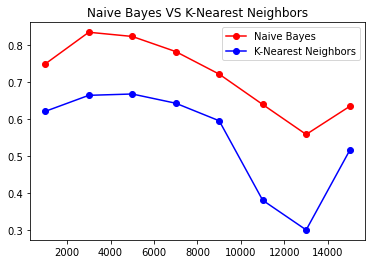

In [27]:
Standards = [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000]
plt.plot(Standards,AccNB, "-ro", label = "Naive Bayes")
plt.plot(Standards,AccKNN, "-bo", label = "K-Nearest Neighbors")
plt.legend(loc='best')
plt.title("Naive Bayes VS K-Nearest Neighbors")


Nhận xét: accuracy của Naive Bayes luôn cao hơn KNN